# Customer Cliff Dive Demo
## Brenna Gibbons

### The problem:
It seems like there has been a drop in engagement for Yammer's customers. The goal is to figure out what is going on and what, if anything, should the company do about it.

### The approach:
I started with a list of hypotheses for what could be causing this drop. Then I sliced the data along various parameters to see if I could localize the issue.

### Results:
It appears that the drop in engagement is most prominent for actions performed on phones and tablets. It is also strongly related to email clickthroughs. The next steps are to see if anything about the mobile platform or email clickthrough links changed around the time of the drop.
***

### Hypotheses:
- This is normal (i.e. a similar pattern occurs every year due to annual holidays, etc).
    - We don't have data for last year handy, so put a pin in that.
    - Check by country/region as proxy for hoidays.
- Logging error. For example, if the 'login' action was incorrectly labeled as type 'signup flow' it might appear that the engagement metric has dropped when it has not.
    - Check engagement by name not just type.
- The platform was updated and something broke.
    - Ask around about major updates, but in the meantime see if we can solve this question with data.
    - Explore 'experiments' data file.
    - Check if it comes from a specific set of users or actions.

### Strategy:
- Slice data along various parameters and plot number of events vs date to look for trends matching the overall engagement drop. Start coarse and move more granular if necessary.
***

In [2]:
# housekeeping
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
!pip install -q pycountry_convert
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

### Import and Join Data

In [4]:
events = pd.read_excel('data/yammer_events.xlsx')
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [5]:
emails = pd.read_excel('data/yammer_emails.xlsx')
emails.head()

,user_id,occurred_at,action,user_type
0,0,2014-05-06 09:30:00,sent_weekly_digest,1
1,0,2014-05-13 09:30:00,sent_weekly_digest,1
2,0,2014-05-20 09:30:00,sent_weekly_digest,1
3,0,2014-05-27 09:30:00,sent_weekly_digest,1
4,0,2014-06-03 09:30:00,sent_weekly_digest,1


In [6]:
users = pd.read_excel('data/yammer_users.xlsx')
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0,2013-01-01 20:59:39,5737,english,2013-01-01 21:01:07,active
1,1,2013-01-01 13:07:46,28,english,NaT,pending
2,2,2013-01-01 10:59:05,51,english,NaT,pending
3,3,2013-01-01 18:40:36,2800,german,2013-01-01 18:42:02,active
4,4,2013-01-01 14:37:51,5110,indian,2013-01-01 14:39:05,active


In [7]:
experiments = pd.read_excel('data/yammer_experiments.xlsx')
experiments.head()

,user_id,occurred_at,experiment,experiment_group,location,device,user_type
0,4,2014-06-05 15:20:16,publisher_update,control_group,India,lenovo thinkpad,3
1,8198,2014-06-11 09:31:32,publisher_update,control_group,Japan,nokia lumia 635,1
2,11,2014-06-17 09:31:22,publisher_update,control_group,United States,iphone 4s,1
3,8209,2014-06-04 09:31:21,publisher_update,test_group,Turkey,nokia lumia 635,1
4,19,2014-06-04 09:31:33,publisher_update,test_group,Nigeria,iphone 5,1


#### Checking Experiments:

In [8]:
# print the first and last experiments chronologically
first_exp = experiments.loc[experiments['occurred_at'].idxmin()]
print(first_exp)
last_exp = experiments.loc[experiments['occurred_at'].idxmax()]
print(last_exp)

user_id                             136
occurred_at         2014-06-01 07:32:11
experiment             publisher_update
experiment_group          control_group
location                          Spain
device                  lenovo thinkpad
user_type                             1
Name: 37, dtype: object
user_id                             124
occurred_at         2014-06-30 09:31:17
experiment             publisher_update
experiment_group          control_group
location                        Germany
device                      macbook air
user_type                             3
Name: 31, dtype: object


None of these updates were near the relevant timeframe, so that's not the source.

### Join data and add custom columns

In [9]:
# inner join columns on user_id
data = pd.merge(events,users, on='user_id')

# create custom timekeeping columns to make plotting easier
# we don't need minute-level data to solve this problem
data['occurred_at_day'] = data.occurred_at.dt.floor('D')
data['occurred_at_week'] = data.occurred_at.dt.floor('D')- pd.to_timedelta(data['occurred_at'].dt.dayofweek, unit='d')
data['activated_at_week'] = data.activated_at.dt.floor('D')- pd.to_timedelta(data['activated_at'].dt.dayofweek, unit='d')
data['activated_at_month'] = data.activated_at.dt.floor('D')- pd.to_timedelta(data['activated_at'].dt.day, unit='d')
data.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state,occurred_at_day,occurred_at_week,activated_at_week,activated_at_month
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31


Helper function for plotting the data without rewriting this call every time.

In [11]:
def plotEventCounts(data,by,times = 'occurred_at_day',kind='line',norm=True,ax=None):
    ax = ax or plt.gca()
    # data will be sliced on 'by'
    # if norm, divide counts by the mean for each group
    if norm:
        myplot = data.groupby(times)[by].value_counts().unstack().transform(lambda x: (x / x.mean())).plot(kind=kind,ax=ax)
        plt.ylabel('normalized event counts')
    else:
        myplot = data.groupby(times)[by].value_counts().unstack().plot(kind=kind,ax=ax)
        plt.ylabel('event counts')
#     plt.legend(ncol=2,loc='lower center')
    # to move legend down, use this line instead:
#     plt.legend(ncol=2,loc='upper center',bbox_to_anchor=(0.5, -0.05))
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(by)
    plt.xlabel('week of occurrance')
    plt.rcParams['figure.dpi'] = 100
    plt.figure(figsize=(6,4))
    return myplot

Look at all the ways we could slice the data:

In [10]:
# get info about columns
for col in data:
    print('Unique {}s: {}'.format(col,len(data[col].unique())))

Unique user_ids: 9760
Unique occurred_ats: 304922
Unique event_types: 2
Unique event_names: 21
Unique locations: 47
Unique devices: 26
Unique user_types: 4
Unique created_ats: 9754
Unique company_ids: 6950
Unique languages: 12
Unique activated_ats: 6141
Unique states: 2
Unique occurred_at_days: 123
Unique occurred_at_weeks: 18
Unique activated_at_weeks: 88
Unique activated_at_months: 21


### Check specific hypotheses

#### Check labeling error:
Check if drop is for all engagement events (not just users) and if a similar drop occurs for signups.

Also starts plotting data with the coarsest comb (2 types)

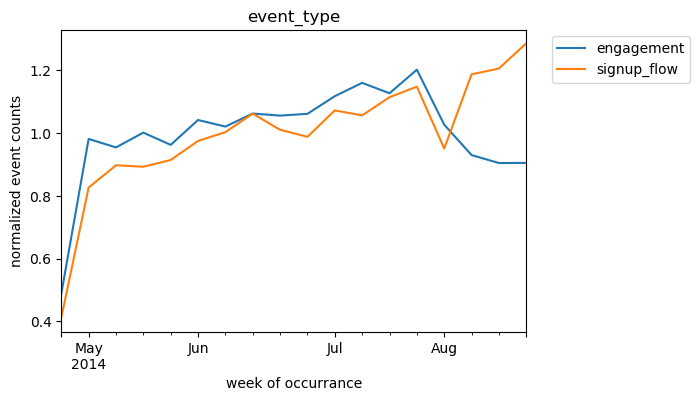

<Figure size 600x400 with 0 Axes>

In [36]:
plotEventCounts(data,'event_type',times='occurred_at_week')

There is also a dip in signups, so it doesn't seem that engagement actions have been mislabeled as signup type.

#### Check holiday:
Check if drop is for all countries/regions.

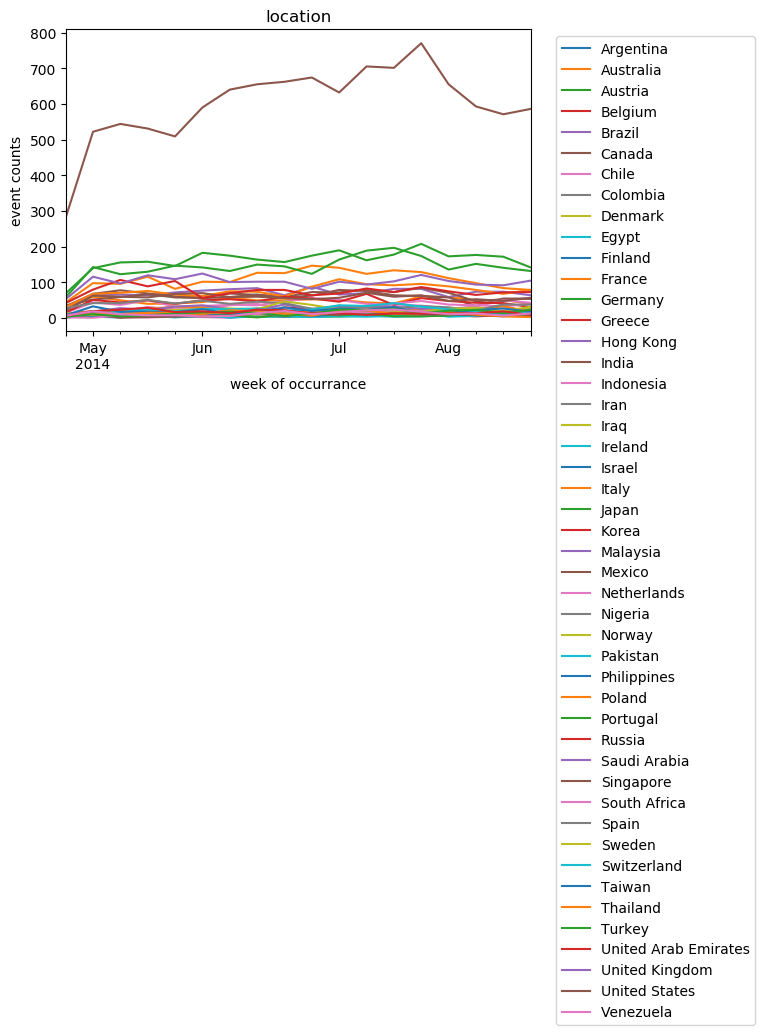

<Figure size 600x400 with 0 Axes>

In [13]:
plotEventCounts(data[data['event_name'] == 'login'],'location',times='occurred_at_week',norm=False)

In [14]:
# map countries to regions so it's easier to see
def countryMapper(country):
    if country == 'Korea':
        country = 'Korea, Republic of'
    country_code = country_name_to_country_alpha2(country, cn_name_format="default")
    return country_alpha2_to_continent_code(country_code)

In [37]:
data['continent'] = data['location'].map(lambda x: countryMapper(x))
data.head(2)

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state,occurred_at_day,occurred_at_week,activated_at_week,activated_at_month,continent,event_name_mod,device_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,login,laptop
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,home_page,laptop


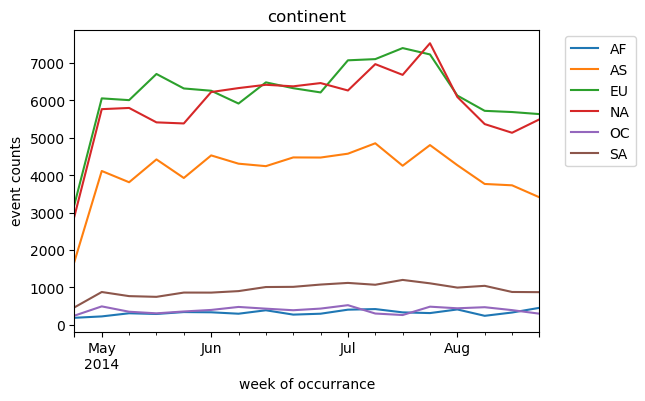

<Figure size 600x400 with 0 Axes>

In [39]:
plotEventCounts(data[data['event_type'] == 'engagement'],'continent',times='occurred_at_week',norm=False)

North America has the most pronounced dip, but it's present across multiple continents, so it's probably not a cultural holiday.

### Plot all the things
#### Start Slicing Events
start at coarsest, go towards finest
only looking at engagement events

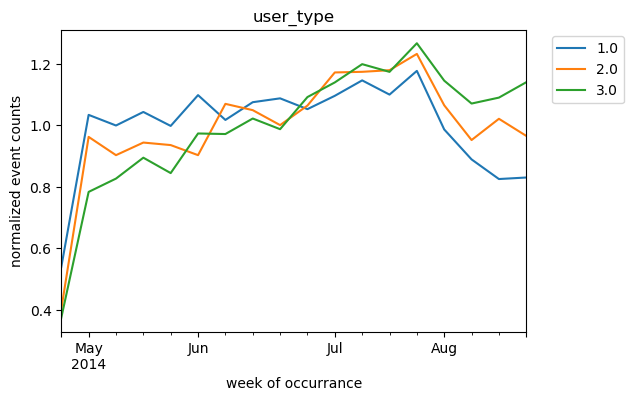

<Figure size 600x400 with 0 Axes>

In [17]:
# user types
plotEventCounts(data[data['event_type'] == 'engagement'],'user_type',times='occurred_at_week')

Similar for all, not the issue

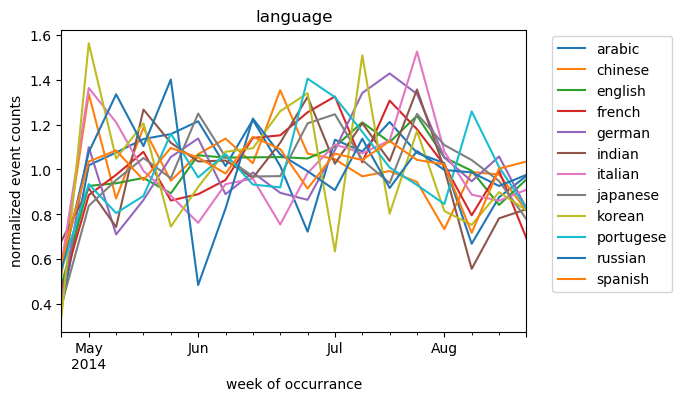

<Figure size 600x400 with 0 Axes>

In [18]:
# language
plotEventCounts(data[data['event_type'] == 'engagement'],'language',times='occurred_at_week',norm=True)

Similar, not the issue

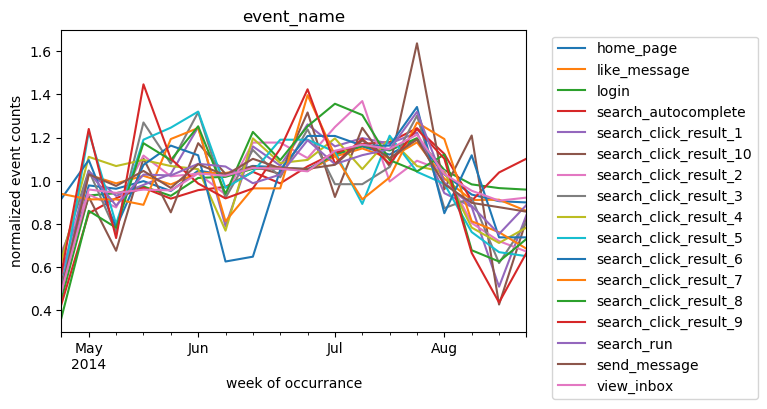

<Figure size 600x400 with 0 Axes>

In [19]:
# event names
plotEventCounts(data[data['event_type'] == 'engagement'],'event_name',times='occurred_at_week',norm=True)

In [20]:
# we don't need details about which search result was clicked on
def compress_search_results(eventname):
    words = eventname.split('_')
    if words[-1].isnumeric():
        return 'search_click_result'
    else:
        return eventname

In [21]:
data['event_name_mod'] = data.event_name.map(lambda x: compress_search_results(x))
data.head(2)

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state,occurred_at_day,occurred_at_week,activated_at_week,activated_at_month,continent,event_name_mod
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,login
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,home_page


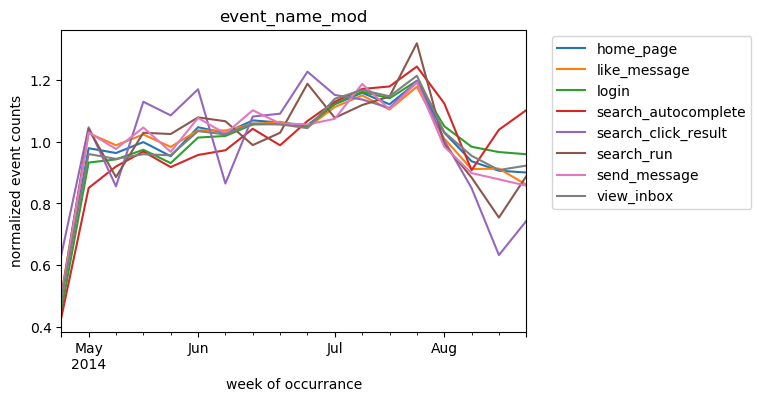

<Figure size 600x400 with 0 Axes>

In [22]:
plotEventCounts(data[data['event_type'] == 'engagement'],'event_name_mod',times='occurred_at_week',norm=True)

Similar, not the issue

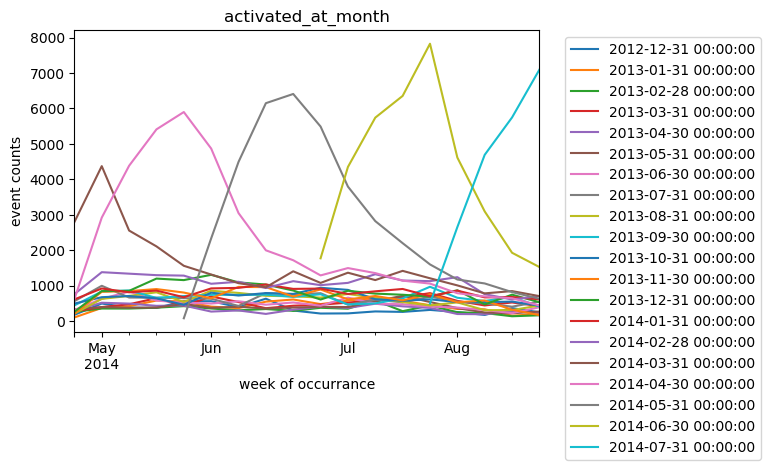

<Figure size 600x400 with 0 Axes>

In [23]:
# how long the users have been activated, binned into months
plotEventCounts(data[data['event_type'] == 'engagement'],'activated_at_month',times='occurred_at_week',norm=False)

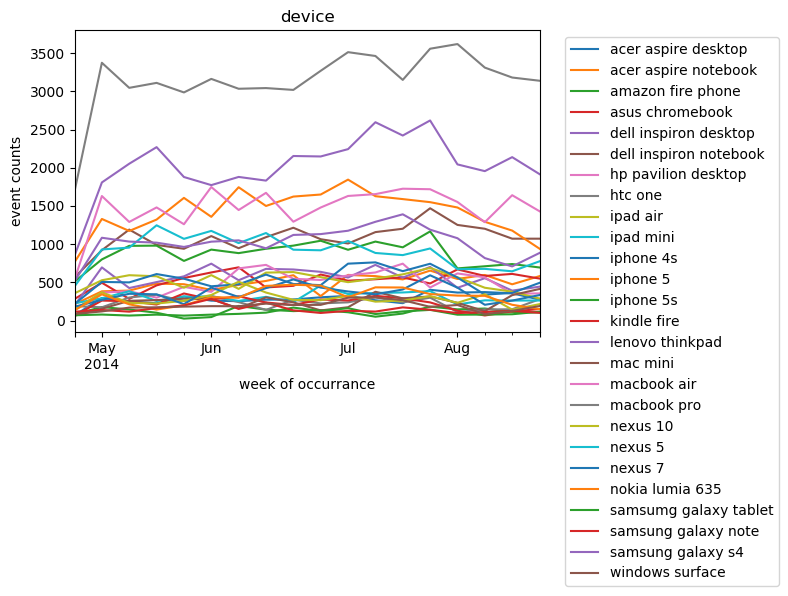

<Figure size 600x400 with 0 Axes>

In [24]:
# devices
plotEventCounts(data[data['event_type'] == 'engagement'],'device',times='occurred_at_week',norm=False)

In [25]:
# convert from specific devices to device type
device_define = {'phone':['iphone 5s','iphone 5','iphone 4s','samsung galaxy s4','htc one',
                       'nokia lumia 635','samsung galaxy note','amazon fire phone'],
              'tablet':['nexus 10','kindle fire','nexus 7','ipad mini','nexus 5',
                       'ipad air','samsumg galaxy tablet'],
              'desktop':['dell inspiron desktop','hp pavilion desktop','mac mini','acer aspire desktop'],
              'laptop':['dell inspiron notebook','lenovo thinkpad','macbook air','windows surface',
                       'macbook pro','acer aspire notebook','asus chromebook']}
device_dict = {}
for k,v in device_define.items():
    for d in v:
        device_dict[d] = k
# device_dict

In [26]:
# map devices to device type
device_df = pd.DataFrame({'device':data.device.unique()})
device_df['device_type'] = device_df.device.map(lambda x: device_dict[x])
data = pd.merge(data,device_df, on='device')
data.head(2)

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state,occurred_at_day,occurred_at_week,activated_at_week,activated_at_month,continent,event_name_mod,device_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,login,laptop
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147,japanese,2014-04-04 16:49:36,active,2014-05-02,2014-04-28,2014-03-31,2014-03-31,AS,home_page,laptop


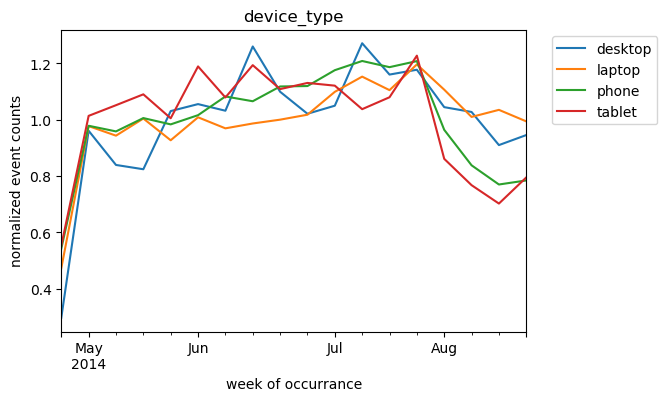

<Figure size 600x400 with 0 Axes>

In [27]:
# now we can look at events by coarser device type
plotEventCounts(data[data['event_type'] == 'engagement'],'device_type',times='occurred_at_week',norm=True)

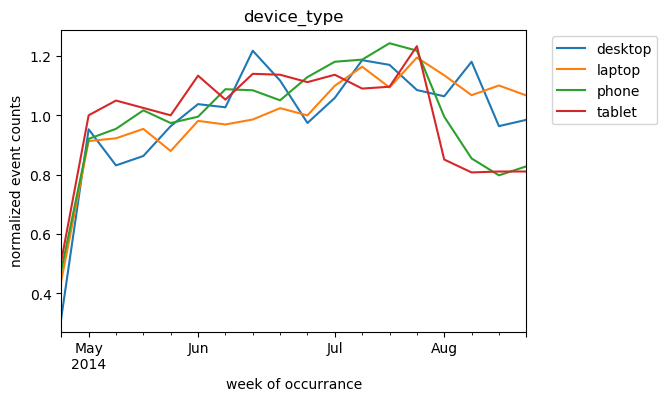

<Figure size 600x400 with 0 Axes>

In [28]:
plotEventCounts(data[data['event_name'] == 'login'],'device_type',times='occurred_at_week',norm=True)

### Bingo!
##### Phones and tablets are (at least part of) the problem
Any specific type?

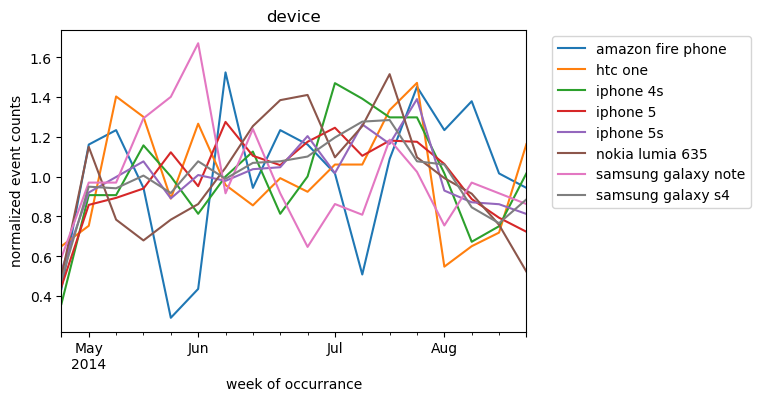

<Figure size 600x400 with 0 Axes>

In [29]:
plotEventCounts(data[(data['event_name'] == 'login') & (data['device_type'] == 'phone')],'device',times='occurred_at_week',norm=True)

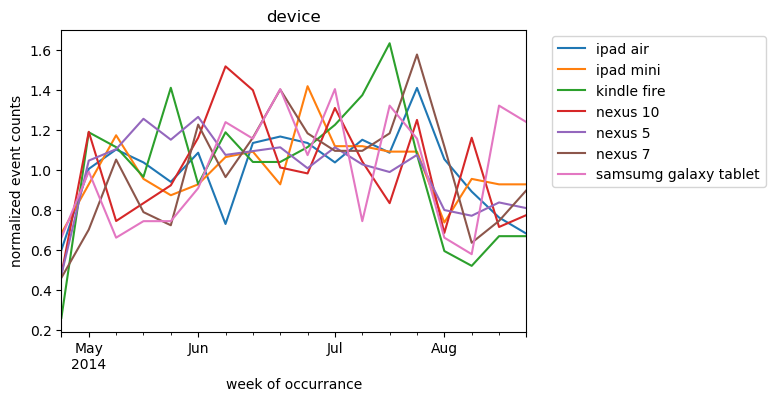

<Figure size 600x400 with 0 Axes>

In [30]:
plotEventCounts(data[(data['event_name'] == 'login') & (data['device_type'] == 'tablet')],'device',times='occurred_at_week',norm=True)

But what is it about phones and tablets? Let's focus on phones for a moment:

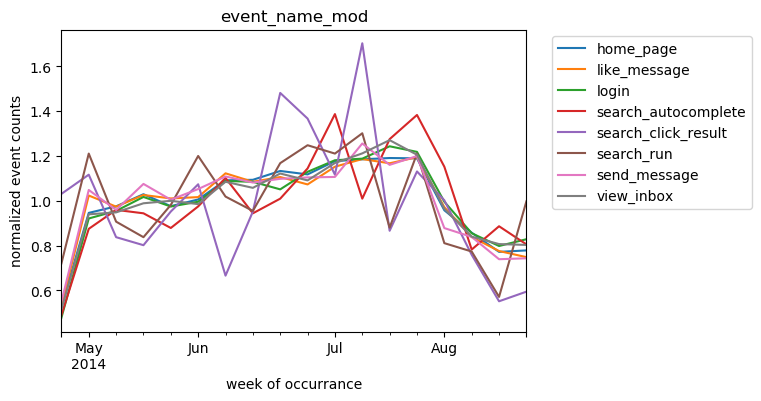

<Figure size 600x400 with 0 Axes>

In [31]:
plotEventCounts(data[(data['device_type'] == 'phone') & (data['event_type'] == 'engagement')],'event_name_mod',times='occurred_at_week',norm=True)

Seems to be equally problematic across all engagement actions.
What about emails?

In [32]:
# same custom columns for date so we can do the plotting:
emails['occurred_at_day'] = emails.occurred_at.dt.floor('D')
emails['occurred_at_week'] = emails.occurred_at.dt.floor('D')- pd.to_timedelta(emails['occurred_at'].dt.dayofweek, unit='d')
emails.head(2)

,user_id,occurred_at,action,user_type,occurred_at_day,occurred_at_week
0,0,2014-05-06 09:30:00,sent_weekly_digest,1,2014-05-06,2014-05-05
1,0,2014-05-13 09:30:00,sent_weekly_digest,1,2014-05-13,2014-05-12


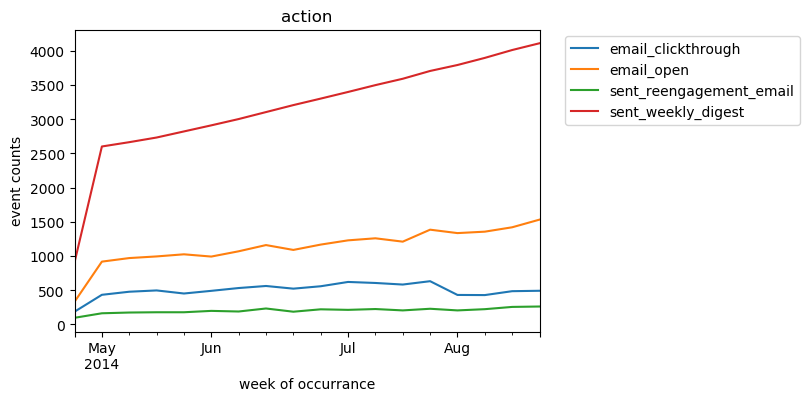

<Figure size 600x400 with 0 Axes>

In [33]:
plotEventCounts(emails,'action',times='occurred_at_week',norm=False)

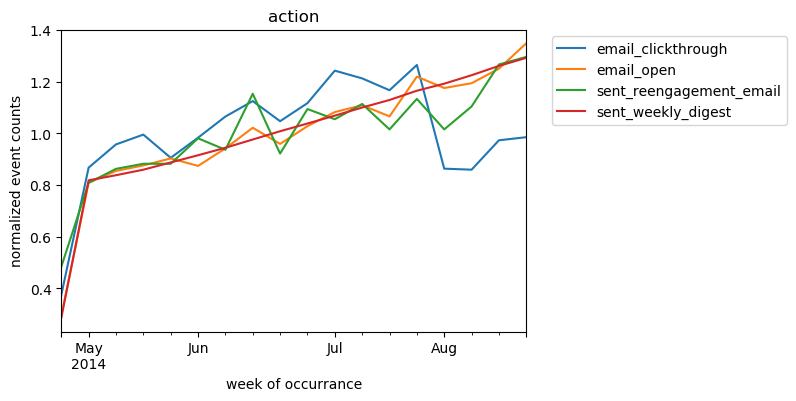

<Figure size 600x400 with 0 Axes>

In [34]:
plotEventCounts(emails,'action',times='occurred_at_week',norm=True)

### Bingo again!
Email clickthroughs have a clear drop as well, indicating that this is part of the problem.
## -------------

### Takeaways
Both device type and email clickthroughs seem to be problems. Talk to these teams to figure out if anything recently changed!

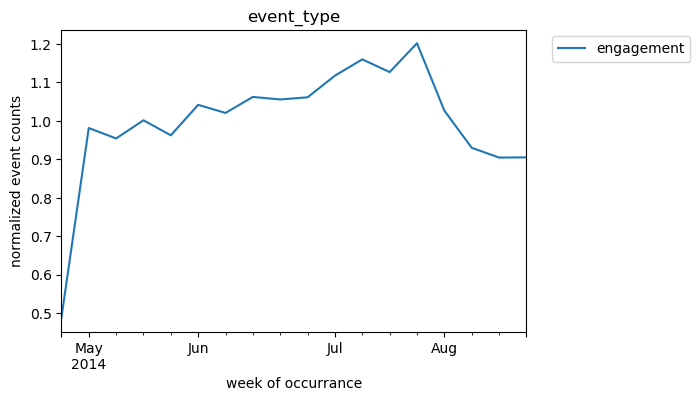

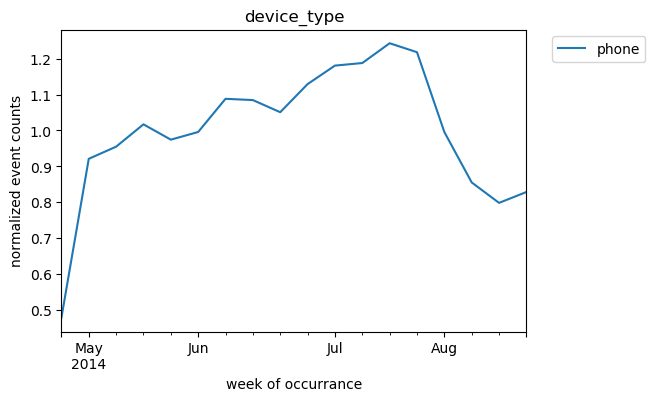

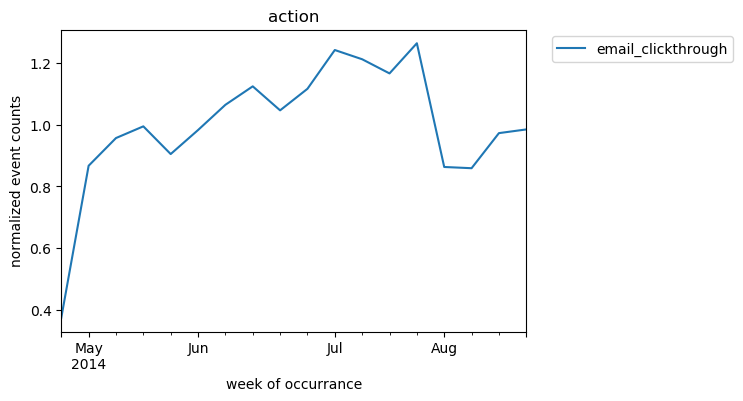

<Figure size 600x400 with 0 Axes>

In [35]:
overall_eng = plotEventCounts(data[data['event_type'] == 'engagement'],'event_type',times='occurred_at_week')
device_type_eng = plotEventCounts(data[(data['event_name'] == 'login') & (data['device_type'] == 'phone')],'device_type',times='occurred_at_week',norm=True)
plotEventCounts(emails[emails['action'] == 'email_clickthrough'],'action',times='occurred_at_week',norm=True)